In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pd.options.mode.chained_assignment = None 

# Project: Predicting customer Lifetime value (LTV) in Ad-based Freemium Mobile Game

## Giới thiệu vấn đề
- Lifetime value (LTV) là tổng giá trị mà một người dùng bất kỳ mang lại. Việc dự đoán giá trị LTV giúp doanh nghiệp giải quyết nhiều vấn đề. LTV là giá trị được dùng rất nhiều trong các ứng dụng mobile nói chung và game mobile nói riêng.
- Đối với mô hình Freemium, đặc biệt là những mô hình tập trung vào doanh thu từ advertisement (ad), có những thách thức khi phân tích cần phải lưu ý, có thể kể đến các vấn đề nêu sau:
    - Nhiều nguồn doanh thu đến từ các mediation khác nhau và mang lại các giá trị khác nhau.
    - Tỷ lệ conversion thấp: phần lớn user không sẵn lòng xem ad hay thanh toán trong game (IAP)
    - Tỷ lệ retention thấp: người chơi bỏ game rất sớm
    - Có sự biến động lớn trong hành vi giữa các người chơi: hai người chơi trong cùng 1 bối cảnh có thể có hành động khác biệt nhau dẫn đến noise trong behavior khá cao)
    - Data có long tail: cụ thể phân phối của dữ liệu sẽ bị lệch phải (right skewed) do phần lớn người chơi đem lại doanh thu rất ít, trong khi đó 1 lượng nhỏ người chơi mang lại doanh thu khá cao.
- Project này được thực hiện để tìm ra một hướng đi cũng như prototype cụ thể và phù hợp để có thể áp dụng vào việc dự đoán LTV và đem lại những insights có ích cho marketer cũng như product owner. 
- Project này được chia ra 3 phần chính: Exploratory Analysis, Segment Analysis, và áp dụng supervised learning sử dụng thông số ngày thứ 3 (D3 metrics) để dự đoán LTV. 

## Data
- Data được sử dụng là Bubble Classic iOS (BCi). Data được lấy trong khoảng thời gian từ 07/05/2021 đến 18/08/2021, tổng cộng 103 ngày. Sau đó, data được clean và process để chuyển thành dạng cohort theo từng user (tập hợp những user cài đặt trong cùng 1 ngày install date), và mỗi cohort ta sẽ có giá trị của các chỉ số D45. 

## Preprocess Data
* Bước đầu tiên, ta phải làm sạch và đưa dữ liệu về dạng chuẩn để đưa vào phân tích
### Preprocess:
- Loại bỏ các record có retention nhỏ hơn 0
- Chuyển install date thành định dạng ngày



In [44]:
def preprocess(data):  
    data = data[data.day_diff >= 0] 
    data['day0_date'] = pd.to_datetime(data['day0_date'])
    return data

- Chia data thành 2 loại là dimension và fact
2. Dimension table:
- Bao gồm các columns: id, day0_date, country, media_source, day_diff
- Group data lại thành individual level, lấy min day0_date, min country, min media_source và max day_diff
- Đối với media source, chia data thành 2 dummies: 0 (Organic) và 1 (Paid)
- Đối với country: 0 (US), 1 (Others)
- Chuyển day0_date thành ordinal data với Monday:0, Tuesday:1, ..., Sunday:6. Data này giúp định nghĩa sự tác động của ngày install game trong tuần lên revenue
- Chuẩn hóa các columns name: USER_ID, INSTALL_DOW, COUNTRY, UA_TYPE, RET_DAYS

In [23]:
def dimension(data):
# Define dimension metrics
    dimension = ['resettable_device_id_or_app_instance_id','day0_date', 'country', 'media_source', 'day_diff']    #, 'TIME_RV_FIRST', 'TIME_IS_FIRST']
# Group dimension by id
    data_dim = data[dimension].groupby('resettable_device_id_or_app_instance_id').agg({'day0_date':'min', 'country':'min', 'media_source':'min', 'day_diff':'max'})   #, 'TIME_RV_FIRST': 'min', 'TIME_IS_FIRST':'min'})
# Dummy media_source and country
    data_dim.loc[data_dim.media_source == 'Organic', 'media_source']= 0
    data_dim.loc[data_dim.media_source != 0,'media_source']= 1 
    data_dim.loc[data_dim.country == 'China', 'country'] = 0
    data_dim.loc[data_dim.country != 0, 'country'] = 1
# Change country and media_source (dummy) into integer data type
    data_dim['country'] = data_dim.country.astype('int')
    data_dim['media_source'] = data_dim.media_source.astype('int')
# Turn day0_date into day of week
    data_dim['day0_date'] = data_dim['day0_date'].dt.dayofweek
    data_dim.reset_index(inplace=True)
# Change columns name
    # data_dim.columns = ['USER_ID', 'INSTALL_DOW', 'COUNTRY', 'UA_TYPE', 'RET_DAYS'] #  , 'TIME_RV_FIRST', 'TIME_IS_FIRST']
    return data_dim

3. Fact table:
- Group data theo id thành các aggregated data theo day_diff là D3 và D45, các metrics sẽ được sum lại với nhau
- Sau đó join data dimension với D3 và D45, hình thành một bảng fact hoàn chỉnh để đưa vào phân tích và model
- Aggregate data bao gồm: AGG_SES, AGG_TIME, AGG_BATTLE_END, AGG_RV_IMP, AGG_IS_IMP, AGG_RV_VAL, AGG_IS_VAL, AGG_IAP_COUNT, AGG_IAP_VAL, AGG_LTV

In [24]:
def aggregate(data):
# Define fact columns
    dimension = ['day0_date','country', 'media_source'] #, 'TIME_RV_FIRST', 'TIME_IS_FIRST']
    data_cols = list(data.columns)
    aggregate = [i for i in data_cols if i not in dimension]
# Group fact data by id and day_diff
    data_aggregated = data[aggregate].groupby(['resettable_device_id_or_app_instance_id','day_diff']).agg('sum')
    data_aggregated = data_aggregated.fillna(0).reset_index()   

    # data_aggregated['rv_fill_rate'] = data_aggregated['rv_imp_sum'] / data_aggregated['rv_click_sum']
    # data_aggregated['is_fill_rate'] = data_aggregated['is_imp_sum'] / data_aggregated['is_click_sum']
# Drop unuseful columns
    try:
        data_aggregated.drop(columns = ['rv_click_sum', 'is_click_sum'], inplace=True)
    except:
        pass

    # DATA_D0 = data_aggregated[data_aggregated.day_diff <= 0].groupby('resettable_device_id_or_app_instance_id').agg('sum').drop(columns = 'day_diff')
    # DATA_D1 = data_aggregated[data_aggregated.day_diff <= 1].groupby('resettable_device_id_or_app_instance_id').agg('sum').drop(columns = 'day_diff')
    DATA_D3 = data_aggregated[data_aggregated.day_diff <= 3].groupby('resettable_device_id_or_app_instance_id').agg('sum').drop(columns = 'day_diff')
    DATA_D30 = data_aggregated[data_aggregated.day_diff <= 30].groupby('resettable_device_id_or_app_instance_id').agg('sum').drop(columns = 'day_diff')
    # for i in [DATA_D0, DATA_D1, DATA_D3, DATA_D45]:
    #     i.columns = ['AGG_SES', 'AGG_TIME', 'AGG_BATTLE_END',
    # 'AGG_RV_IMP','AGG_RV_VAL', 'AGG_IS_IMP', 'AGG_IS_VAL', 'AGG_IAP_COUNT', 'AGG_IAP_VAL', 
    # 'AGG_AD_VAL', 'AGG_LTV']
    # DATA_D0 = DATA_D0.add_suffix('_D0')
    # DATA_D1 = DATA_D1.add_suffix('_D1')
    DATA_D3 = DATA_D3.add_suffix('_D3')
    DATA_D30 = DATA_D30.add_suffix('_LTV')
    
    # AGG_DATA = DATA_D0.merge(DATA_D1, on = 'resettable_device_id_or_app_instance_id'). \
    #     merge(DATA_D3,on = 'resettable_device_id_or_app_instance_id' ). \
    #         merge(DATA_D45, on = 'resettable_device_id_or_app_instance_id').reset_index()
    AGG_DATA = DATA_D3.merge(DATA_D30, on = 'resettable_device_id_or_app_instance_id').reset_index()
    # AGG_DATA = AGG_DATA.rename(columns = {'resettable_device_id_or_app_instance_id':'USER_ID'})
    return AGG_DATA

Join bảng fact và dimension với nhau, thu được data hoàn chỉnh để đưa vào phân tích và dự đoán 

In [25]:
def get_data(data):
    d = preprocess(data)
    dim = dimension(d)
    agg = aggregate(d)
    df = dim.merge(agg, on='resettable_device_id_or_app_instance_id')
    return df

In [26]:
BCiCN = pd.read_csv(r"C:\Users\Muc\Desktop\Dev_LTV_predict\train_data\BCiCN_train_2021-10-28.csv")
BCiCN = BCiCN.rename(columns = {'iap_value_sum':'iap_value', 'ad_value_sum': 'ad_value', 'user_value_sum': 'user_value'})
BCiCN = get_data(BCiCN)
data = BCiCN.copy()

## Exploratory Data Analysis

### Retention


In [7]:
# ret = data.day_diff.value_counts().sort_index()
# ret2 = ret.copy()
# for i in range(0,85):
#     for j in range(i+1,85):
#         ret2[i] = ret2[i] + ret[j]

# rate = ret2/ret2[0] * 100
# plt.bar(rate.index[:46], rate.values[:46])


<BarContainer object of 46 artists>

Sau ngày 1 có khoảng hơn 60% user trở lại và đến ngày thứ 45 xấp xỉ có 15% user còn chơi. Đây là những thông số tốt cho một game casual

In [9]:
data.columns

Index(['resettable_device_id_or_app_instance_id', 'day0_date', 'country',
       'media_source', 'day_diff', 'time_in_game_sum_D3', 'battle_end_sum_D3',
       'session_sum_D3', 'app_exception_fatal_sum_D3',
       'app_exception_non_fatal_sum_D3', 'is_imp_sum_D3', 'rv_imp_sum_D3',
       'is_ad_value_D3', 'rv_ad_value_D3', 'bn_ad_value_D3', 'user_value_D3',
       'iap_value_D3', 'iap_count_D3', 'ad_value_D3', 'time_in_game_sum_LTV',
       'battle_end_sum_LTV', 'session_sum_LTV', 'app_exception_fatal_sum_LTV',
       'app_exception_non_fatal_sum_LTV', 'is_imp_sum_LTV', 'rv_imp_sum_LTV',
       'is_ad_value_LTV', 'rv_ad_value_LTV', 'bn_ad_value_LTV',
       'user_value_LTV', 'iap_value_LTV', 'iap_count_LTV', 'ad_value_LTV'],
      dtype='object')

In [8]:
import seaborn as sns

sns.catplot(data=data.query("session_sum_LTV < 10 &  session_sum_LTV>0") ,x="session_sum_LTV", col ="media_source", kind='count' )

Từ biểu đồ trên, ta thấy hầu hết người chơi của cả hai nguồn UA chỉ chơi 1 session rồi từ bỏ. Với hơn 4500 và 7500 user lần lượt ở nguồn user Organic và Paid ta có thể thực hiện một bài phân tích để tìm hiểu lý do họ từ bỏ game và từ đó cải thiện retention của user. Hơn nữa, nếu có thể dự đoán user nào bỏ game, ta có thể gán giá trị hiện thời của người đó là LTV và loại khỏi model dự đoán LTV. Điều này có khả năng sẽ cải thiện model bởi người chơi drop game sớm chiếm 1 phần khá lớn và ta có thể giảm thiểu noise khỏi phần user còn lại.  

### Payers vs. Non-payers

In [ ]:
# Thêm cột payer, gán giá trị 1 vào user có LTV D45 > 0, còn lại gán giá trị 0
data_payer=data.copy()
data_payer['payer'] = data.user_value_sum_LTV.apply(lambda x: 1 if x > 0 else 0)
sns.catplot(data=data_payer, x ='payer', kind='count', col = 'media_source', legend=True)
plt.legend(labels =['non-payer', 'payer'])

In [ ]:
data.columns

In [41]:
data.groupby('media_source')['iap_value_LTV', 'rv_ad_value_LTV', 'is_ad_value_LTV' ].sum()

C:\Users\Muc\AppData\Local\Temp/ipykernel_20032/589904598.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data.groupby('media_source')['iap_value_LTV', 'rv_ad_value_LTV', 'is_ad_value_LTV' ].sum()


,iap_value_LTV,rv_ad_value_LTV,is_ad_value_LTV
media_source,,,
0,0.0,1870.613289,6660.762455
1,0.0,6062.630899,21371.460053


Người chơi từ paid traffic đem lại value nhiều hơn ở nguồn doanh thu từ ad khi chiếm tới 75% doanh thu từ ad. Trong khi đó doanh thu từ IAP chiếm trọng số rất thấp và không có sự khác biệt đáng kể giữa 2 nguồn traffic.

In [ ]:
data.columns

In [ ]:
col = ['AGG_IAP_COUNT_D45', 'AGG_IAP_VAL_D45', 'AGG_RV_IMP_D45', 'AGG_RV_VAL_D45', 'AGG_IS_IMP_D45', 'AGG_IS_VAL_D45']
data_rev = data[col]
corr = data_rev.corr(method= "spearman")
corr.style.background_gradient(cmap='coolwarm')

In [14]:
data.groupby('media_source').agg({"user_value_LTV":['mean', 'median']})

user_value_LTV          
                       mean    median
media_source                         
0                  0.210969  0.041980
1                  0.229990  0.060548

In [15]:
data.user_value_LTV.describe()

count    173268.000000
mean          0.225201
std           0.638408
min           0.000000
25%           0.012241
50%           0.056119
75%           0.174941
max          42.986892
Name: user_value_LTV, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='AGG_LTV_D45', ylabel='Density'>

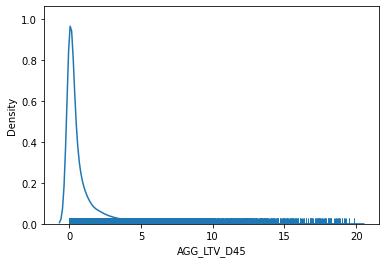

In [122]:
sns.distplot(data[data.AGG_LTV_D45 < 20].AGG_LTV_D45, rug = True, hist=False)

## Machine Learning
- Ở phần này, ta sẽ sử dụng data của 4 ngày đầu tiên (D3) từ khi user cài đặt game để dự đoán LTV (D45) của user.
- Đầu tiên ta sẽ chuẩn hóa data cho việc modeling, sau đó chia data thành 2 tập train và test, và cuối cùng đưa data vào các model XGBoost(XGB), Support Vector Machine (SVM), Neural Network (NN), so sánh performance giữa các model và chọn ra model tốt nhất


In [25]:
# BS.fillna(0, inplace=True)
# (BS.TIME_RV_FIRST == 0).sum(), (BS.TIME_IS_FIRST == 0).sum()
# BS.loc[BS.TIME_RV_FIRST > BS.AGG_TIME_D3, 'TIME_RV_FIRST'] = 0 
# BS.loc[BS.TIME_IS_FIRST > BS.AGG_TIME_D3, 'TIME_IS_FIRST'] = 0

In [16]:
# Prepare data for modeling, query data feature with up to day 3 and target of user value day45                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
df_xgb = BCiCN.copy()
col = ['day0_date', 'country', 'media_source', 'user_value_LTV', 'day_diff'] #, 'TIME_RV_FIRST', 'TIME_IS_FIRST']
a = df_xgb[col]
b = df_xgb.filter(regex='D3')
df_xgb = pd.concat([a,b], axis=1)
df_xgb = df_xgb[df_xgb.day_diff >= 30].drop(columns ='day_diff')

In [28]:
from sklearn.model_selection import train_test_split
X = df_xgb.drop(columns = 'user_value_LTV')
y = df_xgb.user_value_LTV
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)


In [47]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

calc_vif(X)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variables,VIF
0,day0_date,2.324052
1,country,1.003205
2,media_source,2.491854
3,time_in_game_sum_D3,13.997630
4,battle_end_sum_D3,10.310127
5,session_sum_D3,4.067767
6,app_exception_fatal_sum_D3,1.026623
7,app_exception_non_fatal_sum_D3,NaN
8,is_imp_sum_D3,5.462139
9,rv_imp_sum_D3,2.137089


In [29]:
# from sklearn.preprocessing import OneHotEncoder

# # Apply one-hot encoder to each column with categorical data
# OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
# OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[categorical_cols]))
# OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[categorical_cols]))

# # One-hot encoding removed index; put it back
# OH_cols_train.index = X_train.index
# OH_cols_valid.index = X_valid.index

# # Remove categorical columns (will replace with one-hot encoding)
# num_X_train = X_train.drop(categorical_cols, axis=1)
# num_X_valid = X_valid.drop(categorical_cols, axis=1)

# # Add one-hot encoded columns to numerical features
# X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
# X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

In [29]:
import numpy as np
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
from sklearn.metrics import r2_score


space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.choice('n_estimators', range(1000,10000)),
        'seed': 0
      }

def hyperparameter_tuning(space):
    model = xgb.XGBRegressor(n_estimators = space['n_estimators'],
                             max_depth = int(space['max_depth']),
                             gamma = space['gamma'],
                             min_child_weight = space['min_child_weight'],
                             reg_lambda = space['reg_lambda'],
                             reg_alpha = space['reg_alpha'],
                             colsample_bytree = space['colsample_bytree'],
                             eval_metric = 'rmse',
                             seed = 0
                             )
    
    evaluation = [( X_train, y_train), ( X_valid, y_valid)]
    
    model.fit(X_train, y_train,
             eval_set=evaluation, 
             eval_metric="rmse",
             early_stopping_rounds=10,
             verbose = False
             )

  
    pred = model.predict(X_valid)
    score = mean_squared_error(y_valid, pred, squared=False)
    
    print ("SCORE:", score)
    return {'loss':score, 'status': STATUS_OK, 'model': model}
 

trials = Trials()
best = fmin(fn = hyperparameter_tuning,
            space = space,
            algo = tpe.suggest,
            max_evals = 100,
            trials = trials,
            rstate = np.random.RandomState(0)
            )

print(best)

SCORE:
1.1195408482627793
SCORE:
1.1155441180616248
SCORE:
1.1323732573554068
SCORE:
1.0623116743146517
SCORE:
1.1186475861556018
SCORE:
1.0660719984824834
SCORE:
1.1300662545105107
SCORE:
1.1219091328714206
SCORE:
1.1069854914745418
SCORE:
1.1276344644480254
SCORE:
1.0873833379214624
SCORE:
1.093550743374523
SCORE:
1.0516504890176455
SCORE:
1.0792683138131294
SCORE:
1.0805403530232618
SCORE:
1.0931001977113546
SCORE:
1.1229092106937868
SCORE:
1.1058335334052265
SCORE:
1.0549975321011202
SCORE:
1.1111232512120313
SCORE:
1.085289172621663
SCORE:
1.0888169587632546
SCORE:
1.0376373732130966
SCORE:
1.0442165256534022
SCORE:
1.0705574671204705
SCORE:
1.0429067090273398
SCORE:
1.08964912767863
SCORE:
1.0705071511835584
SCORE:
1.0611560358734198
SCORE:
1.0436973066210344
SCORE:
1.0664096868685293
SCORE:
1.0734640273205396
SCORE:
1.0700247175175581
SCORE:
1.0572258843589004
SCORE:
1.0834409722911653
SCORE:
1.0569777435882362
SCORE:
1.0895649064129513
SCORE:
1.128960549905333
SCORE:
1.07552948

In [30]:
best['max_depth'] = int(best['max_depth'])
my_model = xgb.XGBRegressor(**best)
evaluation = [( X_train, y_train), ( X_valid, y_valid)]

my_model.fit(X_train, y_train,
             eval_set=evaluation, 
             eval_metric="rmse",
             early_stopping_rounds=10,
             verbose = False
             )

# Preprocessing of validation data, get predictions
preds = my_model.predict(X_valid)

# Evaluate the model
# tuned_xgb_score = score(preds, y_valid, 'XGB_Tuned')
# score = mean_squared_error(y_valid, preds, squared=False)
# print('MAE:', score)
print(y_valid.sum())
print(preds.sum())
print(r2_score(y_valid, preds))

3118.454039
3062.5237
0.5741460699407537


In [ ]:
3118.4540389999975
3062.5237
0.5741460699407512

In [31]:
print(mean_squared_error(y_valid, preds
, squared=False
))
print(mean_absolute_error(y_valid, preds))

1.0376373732130966
0.43154631510795216


In [39]:
pd.DataFrame(preds).describe()

,0
count,3907.000000
mean,0.783853
std,1.075700
min,0.068176
25%,0.147509
50%,0.390410
75%,1.036613
max,11.819776


In [33]:
y_valid.mean()

0.7981709851548482

In [38]:
y_valid.describe()

count    3907.000000
mean        0.798171
std         1.590270
min         0.000000
25%         0.070905
50%         0.265064
75%         0.889277
max        42.986892
Name: user_value_LTV, dtype: float64

In [36]:
X_train.app_exception_fatal_sum_D3.sum()

411

In [30]:
my_model.save_model('model_2021_10_29.json')

In [40]:
X_train

,day0_date,country,media_source,time_in_game_sum_D3,battle_end_sum_D3,session_sum_D3,app_exception_fatal_sum_D3,app_exception_non_fatal_sum_D3,is_imp_sum_D3,rv_imp_sum_D3,is_ad_value_D3,rv_ad_value_D3,bn_ad_value_D3,user_value_D3,iap_value_D3,iap_count_D3,ad_value_D3
43936,5,0,1,4542.369,23,10,0,0,14,4,0.301371,0.099119,0.066506,0.466996,0.0,0,0.466996
95335,6,0,1,626.797,3,4,0,0,1,0,0.000000,0.000000,0.161328,0.161328,0.0,0,0.161328
126164,0,0,0,15716.428,82,8,0,0,52,7,0.393006,0.093411,0.028871,0.515288,0.0,0,0.515288
52842,5,0,0,10585.035,73,9,0,0,40,17,0.419327,0.309858,0.012902,0.742087,0.0,0,0.742087
35981,3,0,1,5296.937,66,2,0,0,32,1,0.598559,0.030320,0.013251,0.642130,0.0,0,0.642130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84201,3,0,0,4156.396,57,6,0,0,16,1,0.000000,0.000000,0.000000,0.000000,0.0,0,0.000000
118602,1,0,0,780.639,14,3,0,0,4,0,0.053131,0.000000,0.005326,0.058457,0.0,0,0.058457
89887,4,0,1,1319.670,13,3,0,0,5,2,0.050000,0.025000,0.007859,0.082859,0.0,0,0.082859
98749,1,0,1,11378.391,87,6,0,0,43,4,0.180146,0.034841,0.025312,0.240299,0.0,0,0.240299


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

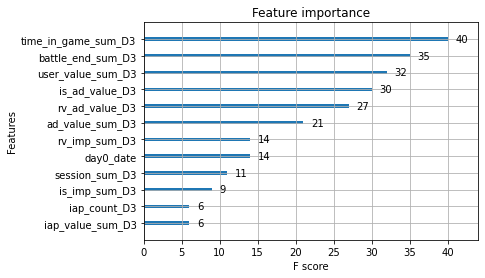

In [ ]:
xgb.plot_importance(my_model)

In [ ]:
def score(preds, valid, index):
    mae = mean_absolute_error(valid, preds)
    r2 = r2_score(valid, preds)
    rmse = mean_squared_error(valid, preds, squared=False)
    score = pd.DataFrame({'RMSE':rmse, 'MAE': mae, "R2": r2}, index =[index])
    return score

In [ ]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train, early_stopping_rounds = 10, eval_set= [(X_valid, y_valid)], verbose=False)
xgb_preds = xgb_model.predict(X_valid)

xgb_score = score(xgb_preds, y_valid, 'XGB_Baseline')

In [ ]:
pd.concat([xgb_score, tuned_xgb_score], axis=0)

,RMSE,MAE,R2
XGB_Baseline,4.109419,1.627478,0.347888
XGB_Tuned,3.573858,1.568105,0.506785


xgb.plot_importance(my_model)

In [ ]:

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [ ]:
df_xgb['TIME_RV_FIRST'].apply(lambda x: 0 if df['TIME_RV_FIRST'] > df.AGG_TIME_D1 else df.TIME_RV_FIRST)

KeyError: 'TIME_RV_FIRST'

In [ ]:
value = df_xgb.columns[df_xgb.columns.str.endswith('D45')]
pd.pivot_table(data=df_xgb, values=value, index='COUNTRY')

EDA


In [ ]:
LTV_45 = df[['AGG_LTV_D45', 'UA_TYPE']]
LTV_45.hist('AGG_LTV_D45', by='UA_TYPE', figsize=(12, 4))

In [ ]:
df.PAYER.value_counts()

1    40446
0     3370
Name: PAYER, dtype: int64

In [ ]:
temp = df.RET_DAYS.value_counts()

In [ ]:
df['PAYER'] = [df.AGG_LTV_D45 > 0 

Text(0.5, 1.02, 'USERS WHO GENERATED NO REVENUE per UA_TYPE')

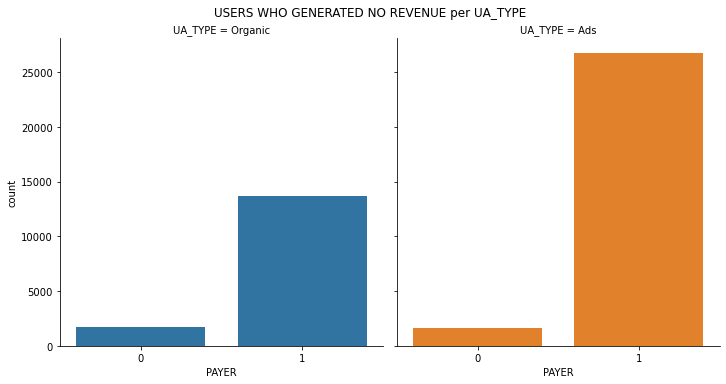

In [ ]:
payer = df[['PAYER', 'UA_TYPE']]
g = sns.catplot(
    x='PAYER',
    data=payer,
    col='UA_TYPE',
    hue='UA_TYPE',
    kind='count',
    dodge=False,
    col_wrap=2,
    legend=True
)
g.fig.suptitle('USERS WHO GENERATED NO REVENUE per UA_TYPE', y=1.02)

Text(0.5, 1.02, 'Session Count per UA_TYPE')

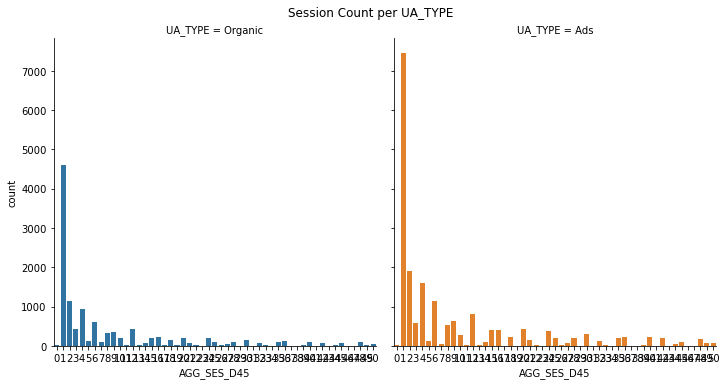

In [ ]:
import seaborn as sns
temp = df[['AGG_SES_D45', 'UA_TYPE']][df.AGG_SES_D45 <=50]
g = sns.catplot(
    x='AGG_SES_D45',
    data=temp,
    col='UA_TYPE',
    hue='UA_TYPE',
    kind='count',
    dodge=False,
    col_wrap=2,
)
g.fig.suptitle('Session Count per UA_TYPE', y=1.02)

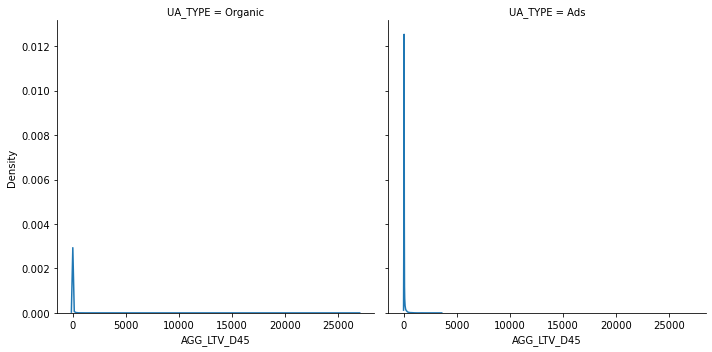

In [ ]:
sns.displot(data=LTV_45, x='AGG_LTV_D45', col='UA_TYPE', kind="kde")  

In [ ]:
df.filter(regex = 'AGG')

NameError: name 'df' is not defined

In [ ]:
import numpy as np

In [ ]:
col = ['UA_TYPE','AGG_RV_VAL_D45','AGG_IS_VAL_D45', 'AGG_AD_VAL_D45','AGG_IAP_VAL_D45', 'AGG_LTV_D45']
rev_summary = df[col]
pd.pivot_table(rev_summary, values=['AGG_RV_VAL_D45','AGG_IS_VAL_D45', 'AGG_AD_VAL_D45','AGG_IAP_VAL_D45', 'AGG_LTV_D45'], index='UA_TYPE', aggfunc=np.sum)

,AGG_AD_VAL_D45,AGG_IAP_VAL_D45,AGG_IS_VAL_D45,AGG_LTV_D45,AGG_RV_VAL_D45
UA_TYPE,,,,,
Ads,41587.983886,647.488936,26754.596397,42235.472822,11992.522589
Organic,19235.723115,1741.796088,12021.682583,20977.519202,5613.529952


In [ ]:
col = ['UA_TYPE','AGG_RV_VAL_D45','AGG_IS_VAL_D45', 'AGG_AD_VAL_D45','AGG_IAP_VAL_D45', 'AGG_LTV_D45']
rev_summary = BC[col]
pd.pivot_table(rev_summary, values=['AGG_RV_VAL_D45','AGG_IS_VAL_D45', 'AGG_AD_VAL_D45','AGG_IAP_VAL_D45', 'AGG_LTV_D45'], index='UA_TYPE', aggfunc=np.sum)

,AGG_AD_VAL_D45,AGG_IAP_VAL_D45,AGG_IS_VAL_D45,AGG_LTV_D45,AGG_RV_VAL_D45
UA_TYPE,,,,,
0,10517.364211,3031.559166,5617.359705,13548.923377,3870.378367
1,31784.750341,2755.854046,17223.067187,34540.604387,11025.974980


In [ ]:
col = ['AGG_RV_VAL_D45','AGG_IS_VAL_D45','AGG_IAP_VAL_D45','AGG_RV_IMP_D45','AGG_IS_IMP_D45','AGG_IAP_COUNT_D45' ]
corr = df[col]
corr_plot = corr.corr()
corr_plot.style.background_gradient(cmap='coolwarm')

,AGG_RV_VAL_D45,AGG_IS_VAL_D45,AGG_IAP_VAL_D45,AGG_RV_IMP_D45,AGG_IS_IMP_D45,AGG_IAP_COUNT_D45
AGG_RV_VAL_D45,1.000000,0.354579,0.154909,0.572903,0.244281,0.191635
AGG_IS_VAL_D45,0.354579,1.000000,0.335876,0.220892,0.409527,0.476142
AGG_IAP_VAL_D45,0.154909,0.335876,1.000000,0.108063,0.056588,0.848489
AGG_RV_IMP_D45,0.572903,0.220892,0.108063,1.000000,0.479248,0.136425
AGG_IS_IMP_D45,0.244281,0.409527,0.056588,0.479248,1.000000,0.069902
AGG_IAP_COUNT_D45,0.191635,0.476142,0.848489,0.136425,0.069902,1.000000


In [ ]:
LTV_SUMMARY = BC[['UA_TYPE', 'AGG_LTV_D45']]
LTV_SUMMARY.groupby('UA_TYPE').agg(['mean', 'median'])

AGG_LTV_D45          
               mean    median
UA_TYPE                      
Ads        1.217634  0.319949
Organic    0.876512  0.121947

In [ ]:
df.filter(regex = '_VAL')[df.AGG_TIME_D45 > 60 ].sum()

AGG_RV_VAL_D0        837.292821
AGG_IS_VAL_D0       2476.952808
AGG_IAP_VAL_D0       208.099715
AGG_AD_VAL_D0       3439.385009
AGG_RV_VAL_D1       1452.602137
AGG_IS_VAL_D1       4059.762529
AGG_IAP_VAL_D1       230.754064
AGG_AD_VAL_D1       5798.460086
AGG_RV_VAL_D7       3440.828117
AGG_IS_VAL_D7       8521.178431
AGG_IAP_VAL_D7       340.139109
AGG_AD_VAL_D7      12839.113388
AGG_RV_VAL_D45      9768.906397
AGG_IS_VAL_D45     20600.052379
AGG_IAP_VAL_D45      813.363106
AGG_AD_VAL_D45     33036.803046
dtype: float64

In [ ]:
df.columns

Index(['USER_ID', 'INSTALL_DOW', 'COUNTRY', 'UA_TYPE', 'RET_DAYS',
       'TIME_RV_FIRST', 'TIME_IS_FIRST', 'AGG_SES_D0', 'AGG_TIME_D0',
       'AGG_BATTLE_END_D0', 'AGG_RV_IMP_D0', 'AGG_RV_VAL_D0', 'AGG_IS_IMP_D0',
       'AGG_IS_VAL_D0', 'AGG_IAP_COUNT_D0', 'AGG_IAP_VAL_D0', 'AGG_AD_VAL_D0',
       'AGG_LTV_D0', 'CONVERSION_RV_D0', 'CONVERSION_IS_D0', 'AGG_SES_D1',
       'AGG_TIME_D1', 'AGG_BATTLE_END_D1', 'AGG_RV_IMP_D1', 'AGG_RV_VAL_D1',
       'AGG_IS_IMP_D1', 'AGG_IS_VAL_D1', 'AGG_IAP_COUNT_D1', 'AGG_IAP_VAL_D1',
       'AGG_AD_VAL_D1', 'AGG_LTV_D1', 'CONVERSION_RV_D1', 'CONVERSION_IS_D1',
       'AGG_SES_D7', 'AGG_TIME_D7', 'AGG_BATTLE_END_D7', 'AGG_RV_IMP_D7',
       'AGG_RV_VAL_D7', 'AGG_IS_IMP_D7', 'AGG_IS_VAL_D7', 'AGG_IAP_COUNT_D7',
       'AGG_IAP_VAL_D7', 'AGG_AD_VAL_D7', 'AGG_LTV_D7', 'CONVERSION_RV_D7',
       'CONVERSION_IS_D7', 'AGG_SES_D45', 'AGG_TIME_D45', 'AGG_BATTLE_END_D45',
       'AGG_RV_IMP_D45', 'AGG_RV_VAL_D45', 'AGG_IS_IMP_D45', 'AGG_IS_VAL_D45',
       'A

In [ ]:
seg_col = ['USER_ID','AGG_LTV_D45', 'AGG_RV_VAL_D45', 'AGG_IAP_VAL_D45', 'AGG_IS_VAL_D45', 'AGG_SES_D45', 'AGG_TIME_D45', 'RET_DAYS'  ]
segment = df[seg_col]

In [ ]:
quantile = segment.quantile([0.5,0.9,0.98])

In [ ]:
quantile.index = ['Minnow','Dolphin','Whale']

In [ ]:
quantile

,AGG_LTV_D45,AGG_RV_VAL_D45,AGG_IAP_VAL_D45,AGG_IS_VAL_D45,AGG_SES_D45,AGG_TIME_D45,RET_DAYS
Minnow,0.138810,0.018120,0.0,0.093486,4.0,2210.35950,6.0
Dolphin,2.499660,0.544039,0.0,1.612499,38.0,43904.34400,112.0
Whale,8.784597,2.774615,0.0,5.156789,118.0,182376.87708,178.0


In [ ]:
def f(df):
    if df['']

In [ ]:
segment['SEGMENT_LTV'] = segment['AGG_LTV_D45'].apply(lambda x: 0)

,USER_ID,AGG_LTV_D45,AGG_RV_VAL_D45,AGG_IAP_VAL_D45,AGG_IS_VAL_D45,AGG_SES_D45,AGG_TIME_D45,RET_DAYS
0,000079A1-6995-480C-8C78-7A409111ED1D,0.000200,0.000000,0.0,0.000000,2,36.548,10
1,00015592-D0B3-4F29-B0ED-B8A072588DD6,0.104910,0.026410,0.0,0.077940,1,390.858,0
2,00064165-BA57-4357-90DB-0C9A18D001B7,2.298080,0.000000,0.0,2.213600,2,6703.246,194
3,000770E8-A904-4AEC-95DD-51BF6483B304,0.399070,0.182660,0.0,0.213430,8,3112.740,13
4,00079778-9D3B-4532-AD21-EDC3E50E551D,0.000000,0.000000,0.0,0.000000,5,1833.487,4
...,...,...,...,...,...,...,...,...
60235,FFFA15F5-60B2-4C01-86C8-EEABD3E43231,0.000000,0.000000,0.0,0.000000,6,5578.448,12
60236,FFFCD19F-D1B1-4C0C-B4DE-37B195C3B4DE,0.001140,0.000000,0.0,0.000000,1,0.001,0
60237,FFFE67F2-EA90-4EEC-94D4-B076C380DBE1,0.721274,0.405107,0.0,0.288737,18,18769.164,124
60238,FFFE7193-0992-4615-A152-9B87B6574073,4.931953,1.396210,0.0,3.081343,32,34769.416,73
